In [1]:
import torch
import requests
from PIL import Image
from io import BytesIO
from matplotlib import pyplot as plt
from tqdm.auto import tqdm


/home/matteoc/miniconda3/envs/speech-meg/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


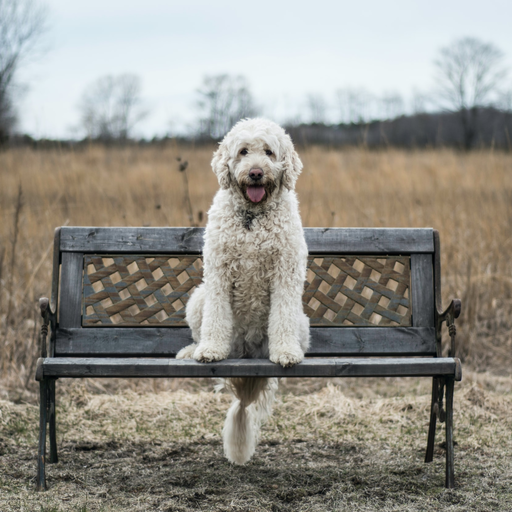

In [7]:
# We'll be exploring a number of pipelines today!
from diffusers import (
    StableDiffusionPipeline,
    StableDiffusionImg2ImgPipeline,
    StableDiffusionInpaintPipeline,
    StableDiffusionDepth2ImgPipeline,
)


# We'll use a couple of demo images later in the notebook
def download_image(url):
    response = requests.get(url)
    return Image.open(BytesIO(response.content)).convert("RGB")


# Download images for inpainting example
img_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo.png"
mask_url = "https://raw.githubusercontent.com/CompVis/latent-diffusion/main/data/inpainting_examples/overture-creations-5sI6fQgYIuo_mask.png"

init_image = download_image(img_url).resize((512, 512))
mask_image = download_image(mask_url).resize((512, 512))
init_image

In [5]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

In [8]:
# Load the pipeline
model_id = "stabilityai/stable-diffusion-2-1-base"
pipe = StableDiffusionPipeline.from_pretrained(model_id).to(device)

Loading pipeline components...: 100%|██████████| 6/6 [00:00<00:00, 11.72it/s]


  0%|          | 0/35 [00:00<?, ?it/s]

100%|██████████| 35/35 [00:03<00:00, 10.39it/s]


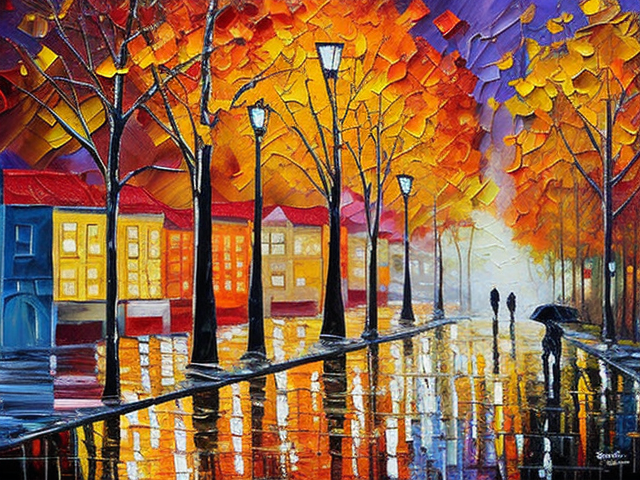

In [16]:
# Set up a generator for reproducibility
generator = torch.Generator(device=device).manual_seed(42)

# Run the pipeline, showing some of the available arguments
pipe_output = pipe(
    prompt="Palette knife painting of an autumn cityscape",  # What to generate
    negative_prompt="Oversaturated, blurry, low quality",  # What NOT to generate
    height=480,
    width=640,  # Specify the image size
    guidance_scale=10,  # How strongly to follow the prompt
    num_inference_steps=35,  # How many steps to take
    generator=generator,  # Fixed random seed
)

# View the resulting image
pipe_output.images[0]

100%|██████████| 35/35 [00:02<00:00, 14.89it/s]


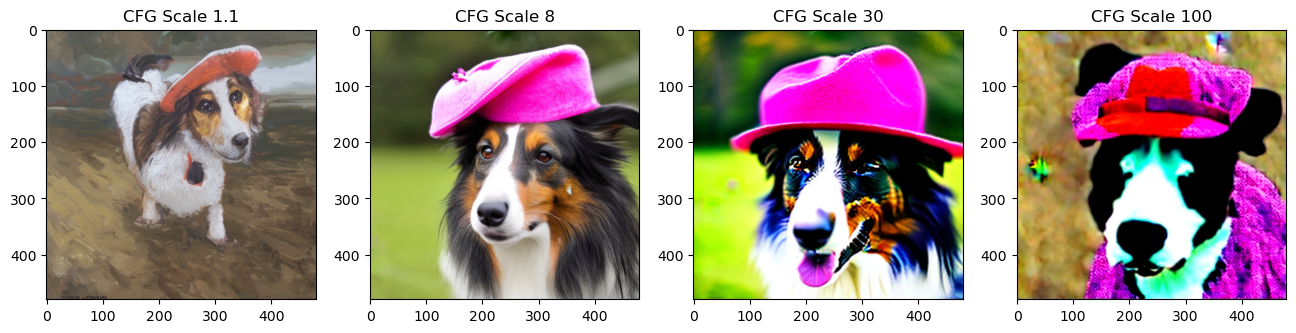

In [73]:
# @markdown comparing guidance scales:
cfg_scales = [1.1, 8, 30, 100]  # @param  --> better 8-12
prompt = "A collie with a pink hat"  # @param
fig, axs = plt.subplots(1, len(cfg_scales), figsize=(16, 5))
for i, ax in enumerate(axs):
    im = pipe(
        prompt,
        height=480,
        width=480,
        guidance_scale=cfg_scales[i],
        num_inference_steps=35,
        generator=torch.Generator(device=device).manual_seed(42),
    ).images[0]
    ax.imshow(im)
    ax.set_title(f"CFG Scale {cfg_scales[i]}")

In [26]:
print(list(pipe.components.keys()))

['vae', 'text_encoder', 'tokenizer', 'unet', 'scheduler', 'safety_checker', 'feature_extractor', 'image_encoder']


In [27]:
# Create some fake data (a random image, range (-1, 1))
images = torch.rand(1, 3, 512, 512).to(device) * 2 - 1
print("Input images shape:", images.shape)

# Encode to latent space
with torch.no_grad():
    latents = 0.18215 * pipe.vae.encode(images).latent_dist.mean
print("Encoded latents shape:", latents.shape)

# Decode again
with torch.no_grad():
    decoded_images = pipe.vae.decode(latents / 0.18215).sample
print("Decoded images shape:", decoded_images.shape)

Input images shape: torch.Size([1, 3, 512, 512])
Encoded latents shape: torch.Size([1, 4, 64, 64])
Decoded images shape: torch.Size([1, 3, 512, 512])


In [28]:
# Tokenizing and encoding an example prompt manually

# Tokenize
input_ids = pipe.tokenizer(["A painting of a flooble"])["input_ids"]
print("Input ID -> decoded token")
for input_id in input_ids[0]:
    print(f"{input_id} -> {pipe.tokenizer.decode(input_id)}")

# Feed through CLIP text encoder
input_ids = torch.tensor(input_ids).to(device)
with torch.no_grad():
    text_embeddings = pipe.text_encoder(input_ids)["last_hidden_state"]
print("Text embeddings shape:", text_embeddings.shape)

Input ID -> decoded token
49406 -> <|startoftext|>
320 -> a
3086 -> painting
539 -> of
320 -> a
4062 -> floo
1059 -> ble
49407 -> <|endoftext|>
Text embeddings shape: torch.Size([1, 8, 1024])


In [33]:
# Get the final text embeddings using the pipeline's encode_prompt function
text_embeddings = pipe.encode_prompt("A painting of a flooble", device, 1, False, "")
text_embeddings[0].shape

torch.Size([1, 77, 1024])

In [35]:
# Dummy inputs
timestep = pipe.scheduler.timesteps[0]
print('timestep: ', timestep)
latents = torch.randn(1, 4, 64, 64).to(device)
text_embeddings = torch.randn(1, 77, 1024).to(device)

# Model prediction
with torch.no_grad():
    unet_output = pipe.unet(latents, timestep, text_embeddings).sample
print("UNet output shape:", unet_output.shape)  # Same shape as the input latents

timestep:  tensor(953, device='cuda:0')
UNet output shape: torch.Size([1, 4, 64, 64])


Scheduler config: LMSDiscreteScheduler {
  "_class_name": "LMSDiscreteScheduler",
  "_diffusers_version": "0.27.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "linspace",
  "trained_betas": null,
  "use_karras_sigmas": false
}



100%|██████████| 50/50 [00:03<00:00, 14.87it/s]


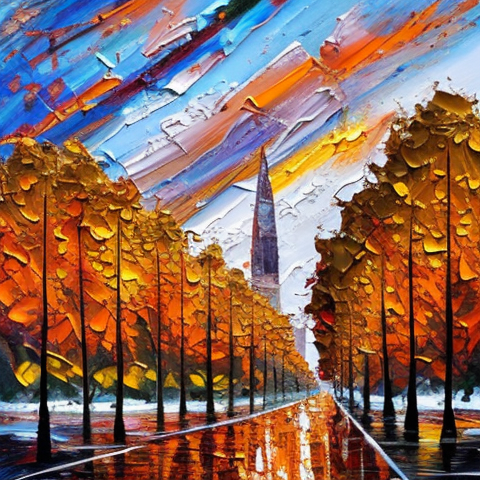

In [36]:
from diffusers import LMSDiscreteScheduler

# Replace the scheduler
pipe.scheduler = LMSDiscreteScheduler.from_config(pipe.scheduler.config)

# Print the config
print("Scheduler config:", pipe.scheduler)

# Generate an image with this new scheduler
pipe(
    prompt="Palette knife painting of an autumn cityscape",
    height=480,
    width=480,
    generator=torch.Generator(device=device).manual_seed(42),
).images[0]

## Put Together

0it [00:00, ?it/s]

150it [00:11, 13.64it/s]


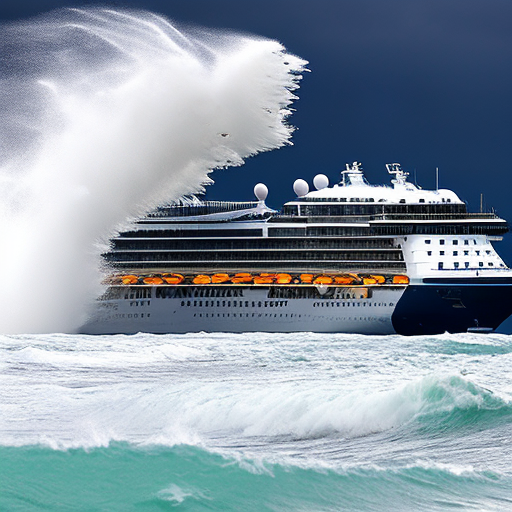

In [68]:
guidance_scale = 9  # @param
num_inference_steps = 150  # @param
prompt = "Picture of a wave breaking over a cruise ship during a storm"  # @param
negative_prompt = "zoomed in, blurry, oversaturated, warped"  # @param

# Encode the prompt
text_embeddings = pipe._encode_prompt(prompt, device, 1, True, negative_prompt)

# Create our random starting point
latents = torch.randn((1, 4, 64, 64), device=device, generator=generator)
latents *= pipe.scheduler.init_noise_sigma

# Prepare the scheduler
pipe.scheduler.set_timesteps(num_inference_steps, device=device)

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(pipe.scheduler.timesteps)):

    # Expand the latents if we are doing classifier free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Apply any scaling required by the scheduler
    latent_model_input = pipe.scheduler.scale_model_input(latent_model_input, t)

    # Predict the noise residual with the UNet
    with torch.no_grad():
        noise_pred = pipe.unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

    # Perform guidance                                         --> chunk per splittare unico tensor in due
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)   # --> we make two separate predictions: one with the text prompt as conditioning and one without
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)   # --> difference between these two predictions to create a final combined prediction that pushes even further in the direction indicated by the text-conditioned prediction according to some scaling factor

    # Compute the previous noisy sample x_t -> x_t-1
    latents = pipe.scheduler.step(noise_pred, t, latents).prev_sample

# Decode the resulting latents into an image
with torch.no_grad():
    image = pipe.decode_latents(latents.detach())

# View
pipe.numpy_to_pil(image)[0]